# Identify and visualize non-overlapping clades

Given an auspice tree, a start date, and an end date, can I partition a tree into non-overlapping clades, annotate all nodes in the clades by their grouping, and visualize the results?

## Import and configure code

In [1]:
import sys
sys.path.insert(0, "../../dist/augur")

In [2]:
from collections import defaultdict
import json
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

from base.frequencies import KdeFrequencies
from base.io_util import json_to_tree

%matplotlib inline

In [3]:
# Configure matplotlib theme.
fontsize = 14
matplotlib_params = {
    'axes.labelsize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 12,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'text.usetex': False,
    'figure.figsize': [6, 4],
    'savefig.dpi': 300,
    'figure.dpi': 120,
    'text.usetex': False
}

plt.rcParams.update(matplotlib_params)

# Turn off spines for all plots.
plt.rc("axes.spines", top=False, right=False)

In [4]:
def plot_tree(tree, kde_frequencies, timepoint, color_by_trait, initial_branch_width, tip_size, start_timepoint,
              end_timepoint, figure_name=None, title=None, min_date=None, max_date=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    mpl.rcParams['savefig.dpi'] = 120
    mpl.rcParams['figure.dpi'] = 100

    mpl.rcParams['font.weight']=300
    mpl.rcParams['axes.labelweight']=300
    mpl.rcParams['font.size']=14

    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    trait_name = color_by_trait
    traits = [k.attr.get(trait_name) for k in tree.find_clades()
              if k.attr.get(trait_name)]
    norm = mpl.colors.Normalize(min(traits), max(traits))
    cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if kde_frequencies:
        fig = plt.figure(figsize=(8, 8), facecolor='w')
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
        ax = fig.add_subplot(gs[0])
        freq_ax = fig.add_subplot(gs[1])
    else:
        fig = plt.figure(figsize=(8, 6), facecolor='w')
        gs = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
        ax = fig.add_subplot(gs[0])
        freq_ax = None

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.up is None:
            xp = None
        else:
            xp=k.up.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = (0.6, 0.6, 0.6)
        if k.attr.has_key(trait_name):
            c = cmap(norm(k.attr[trait_name]))

        branchWidth=2
        if k.is_terminal(): ## if leaf...
            s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(c)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.grid(axis='x',ls='-',color='grey')
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if min_date:
        ax.set_xlim(min_date, max_date)
    
    rectangle = plt.Rectangle((end_timepoint, 0), start_timepoint, y_span, fc='#999999', alpha=0.2)
    ax.add_patch(rectangle)
    
    if kde_frequencies:
        # Recalculate frequencies at this timepoint.
        params = kde_frequencies.get_params()
        params["max_date"] = timepoint
        kde_frequencies = type(kde_frequencies)(**params)
        kde_frequencies.estimate(tree)

        plotted_groups = set()
        for clade in tree.find_clades():
            if trait_name in clade.attr and clade.attr[trait_name] not in plotted_groups:
                c = cmap(norm(clade.attr[trait_name]))
                freq_ax.plot(kde_frequencies.pivots, kde_frequencies.frequencies[clade.name], "-o", color=c)
                plotted_groups.add(clade.attr[trait_name])

        freq_ax.axvline(timepoint, alpha=0.5, color="#999999")
        freq_ax.set_ylim(0, 1.1)

        if min_date:
            freq_ax.set_xlim(min_date, max_date)
    
    if title:
        ax.set_title(title)

    gs.tight_layout(fig)
    
    if figure_name:
        plt.savefig(figure_name)
        
    return ax, freq_ax

## Load an auspice tree

In [5]:
with open("flu_h3n2_ha_2006-2018y_24v_0_tree.json", "r") as fh:
    tree_json = json.load(fh)

tree = json_to_tree(tree_json)

In [6]:
tree

Clade(branch_length=0, clade=3616, name='NODE_0002002', numdate=2004.18074399, strain='NODE_0002002', yvalue=1985.83086672)

In [112]:
kde_frequencies = KdeFrequencies(
    pivot_frequency=6,
    include_internal_nodes=True,
    start_date=2006.75,
    end_date=2018.25,
    sigma_narrow=0.0833,
    proportion_wide=0.0
)
frequencies = kde_frequencies.estimate(tree)

In [113]:
kde_frequencies.get_params()

{'censored': False,
 'end_date': 2018.25,
 'include_internal_nodes': True,
 'max_date': None,
 'pivot_frequency': 6,
 'proportion_wide': 0.0,
 'sigma_narrow': 0.0833,
 'sigma_wide': 0.25,
 'start_date': 2006.75,
 'weights': None,
 'weights_attribute': None}

## Identify clades from a given start date

The general idea for this works as follows for each node in the tree:

  1. If the node's inferred date is greater than or equal to the start date, select it.
  1. If the selected node's parent does not have a clade group and is not a tip, increment the current group number and assign the new number to the node.
  1. Else, assign the parent's group number to the node.
  
This should result in all nodes sampled prior to the start date not having a clade group and only monophyletic groups sampled after the start date being assigned clade groups.

In [23]:
kde_frequencies.pivots

array([ 2006.75,  2007.25,  2007.75,  2008.25,  2008.75,  2009.25,
        2009.75,  2010.25,  2010.75,  2011.25,  2011.75,  2012.25,
        2012.75,  2013.25,  2013.75,  2014.25,  2014.75,  2015.25,
        2015.75,  2016.25,  2016.75,  2017.25,  2017.75,  2018.25])

In [25]:
previous_date = 2016.75
start_date = 2017.25

In [26]:
# Reset attribute on nodes.
for clade in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

tips_in_timepoint = []
clade_group = 0
clades = {}
for clade in tree.find_clades():
    if previous_date <= clade.attr["num_date"] < start_date:
        if "clade_group" in clade.up.attr:
            clade.attr["clade_group"] = clade.up.attr["clade_group"]
        elif not clade.is_terminal():
            clade_group += 1
            clade.attr["clade_group"] = clade_group
            clades[clade_group] = clade
        else:
            tips_in_timepoint.append(clade)

In [27]:
clade_group

28

In [28]:
total_tips = 0
for clade in clades.values():
    clade_tips = len(clade.get_terminals())
    total_tips += clade_tips
    print(clade_tips)

6
2
14
8
5
16
13
19
15
82
2
3
5
4
2
2
2
2
19
2
5
4
2
3
4
48
4
56


In [29]:
total_tips

349

In [30]:
len(tips_in_timepoint)

33

In [31]:
len([tip for tip in tree.get_terminals() if tip.attr["num_date"] >= start_date])

262

## Visualize clades

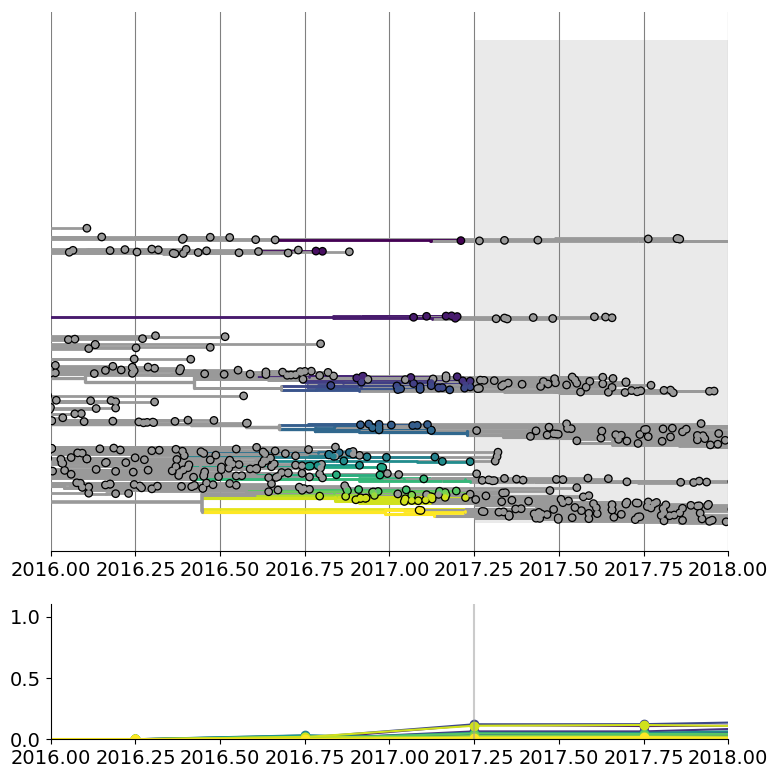

In [32]:
ax, freq_ax = plot_tree(tree, kde_frequencies, start_date, "clade_group", 10, 20, previous_date, start_date,
                        min_date=2016, max_date=2018)

In [33]:
min([clade.attr["num_date"] for clade in tree.find_clades() if "clade_group" in clade.attr])

2016.7575974177585

## Alternate approach: split clades from root

Instead of finding clades at each timepoint extending back in time a fixed amount, start at the root and start splitting from the top down.

  1. Start at the root node
  1. Start at the first timepoint
  1. Find clades alive at the current timepoint
    1. If clades are below a given threshold, omit them.
    1. If clades are between the threshold, add them.
    1. If clades are above the threshold, split them.
      1. If child clades are alive at the current timepoint, add them.
  1. Move to the next timepoint and repeat the steps above

In [34]:
kde_frequencies.pivots

array([ 2006.75,  2007.25,  2007.75,  2008.25,  2008.75,  2009.25,
        2009.75,  2010.25,  2010.75,  2011.25,  2011.75,  2012.25,
        2012.75,  2013.25,  2013.75,  2014.25,  2014.75,  2015.25,
        2015.75,  2016.25,  2016.75,  2017.25,  2017.75,  2018.25])

In [35]:
tree

Clade(branch_length=0, clade=3616, name='NODE_0002002', numdate=2004.18074399, strain='NODE_0002002', yvalue=1985.83086672)

In [36]:
timepoints = kde_frequencies.pivots

In [37]:
min_frequency = 0.05
max_frequency = 0.70

In [38]:
clades_by_timepoint = defaultdict(list)
for clade in tree.find_clades():
    if not clade.is_terminal():
        # Find the range of timepoints from when this clade was first detected
        # to when the clade was last detected. This range will include any timepoints
        # when the clade goes undetected but emerges again later.
        clade_alive = np.argwhere((min_frequency < frequencies[clade.name]) &
                                  (frequencies[clade.name] < max_frequency))
        if len(clade_alive) > 0:
            start_timepoint_index = clade_alive.min()
            end_timepoint_index = clade_alive.max() + 1

            for timepoint in timepoints[start_timepoint_index:end_timepoint_index]:
                clades_by_timepoint[timepoint].append(clade)

In [39]:
unnested_clades_by_timepoint = defaultdict(list)
for timepoint in timepoints:
    nested = 0
    for clade in clades_by_timepoint[timepoint]:
        if clade.up in clades_by_timepoint[timepoint]:
            nested += 1
        else:
            unnested_clades_by_timepoint[timepoint].append(clade)
            
    print("%s: %s clades (%s nested)" % (timepoint, len(clades_by_timepoint[timepoint]), nested))

2006.75: 14 clades (9 nested)
2007.25: 25 clades (18 nested)
2007.75: 41 clades (34 nested)
2008.25: 41 clades (36 nested)
2008.75: 44 clades (42 nested)
2009.25: 43 clades (41 nested)
2009.75: 38 clades (35 nested)
2010.25: 32 clades (27 nested)
2010.75: 36 clades (32 nested)
2011.25: 50 clades (47 nested)
2011.75: 56 clades (54 nested)
2012.25: 82 clades (80 nested)
2012.75: 54 clades (52 nested)
2013.25: 46 clades (44 nested)
2013.75: 58 clades (56 nested)
2014.25: 71 clades (69 nested)
2014.75: 76 clades (74 nested)
2015.25: 72 clades (69 nested)
2015.75: 77 clades (74 nested)
2016.25: 96 clades (93 nested)
2016.75: 113 clades (110 nested)
2017.25: 82 clades (79 nested)
2017.75: 82 clades (79 nested)
2018.25: 69 clades (67 nested)


2006.75: 5 unnested clades totalling 0.753702402271
No children annotated with a clade group at 2006.75
2007.25: 7 unnested clades totalling 0.923397820618
2007.75: 7 unnested clades totalling 0.961016238709
2008.25: 5 unnested clades totalling 0.999685991667
2008.75: 2 unnested clades totalling 0.999999999755
2009.25: 2 unnested clades totalling 0.995715280265
2009.75: 3 unnested clades totalling 0.999752630818
2010.25: 5 unnested clades totalling 0.994500932308
2010.75: 4 unnested clades totalling 0.966193420729
2011.25: 3 unnested clades totalling 0.968665010227
2011.75: 2 unnested clades totalling 0.99816397355
2012.25: 2 unnested clades totalling 0.99999833011
2012.75: 2 unnested clades totalling 0.920545189187
2013.25: 2 unnested clades totalling 0.905887069951
2013.75: 2 unnested clades totalling 0.998879524043
2014.25: 2 unnested clades totalling 0.999999610876
2014.75: 2 unnested clades totalling 0.999999999993
2015.25: 3 unnested clades totalling 0.891329029052
2015.75: 3 unn

/Users/jlhudd/miniconda3/envs/janus_python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2017.75: 3 unnested clades totalling 0.935444448224
2018.25: 2 unnested clades totalling 0.960558296341


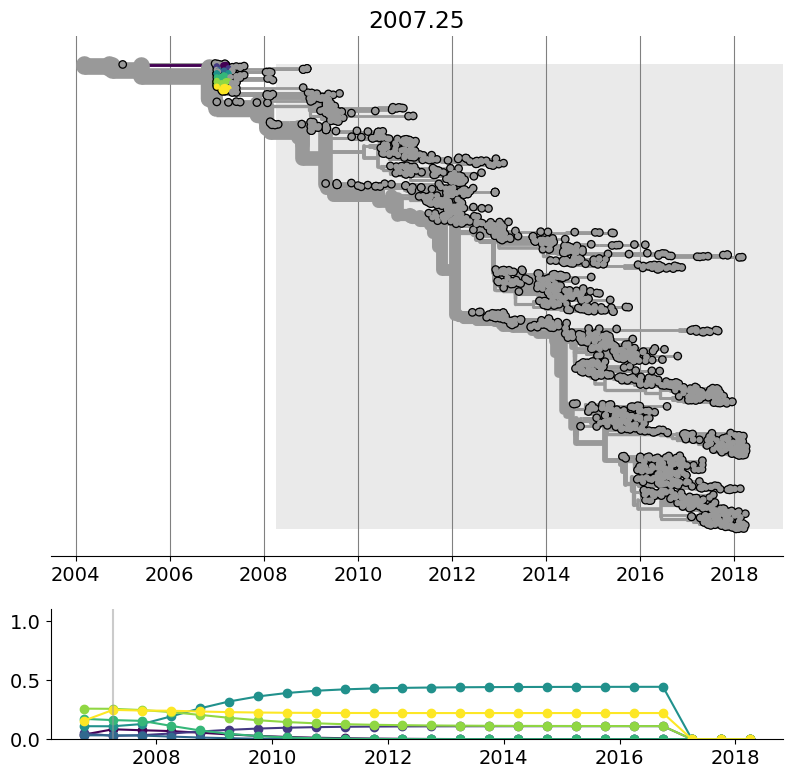

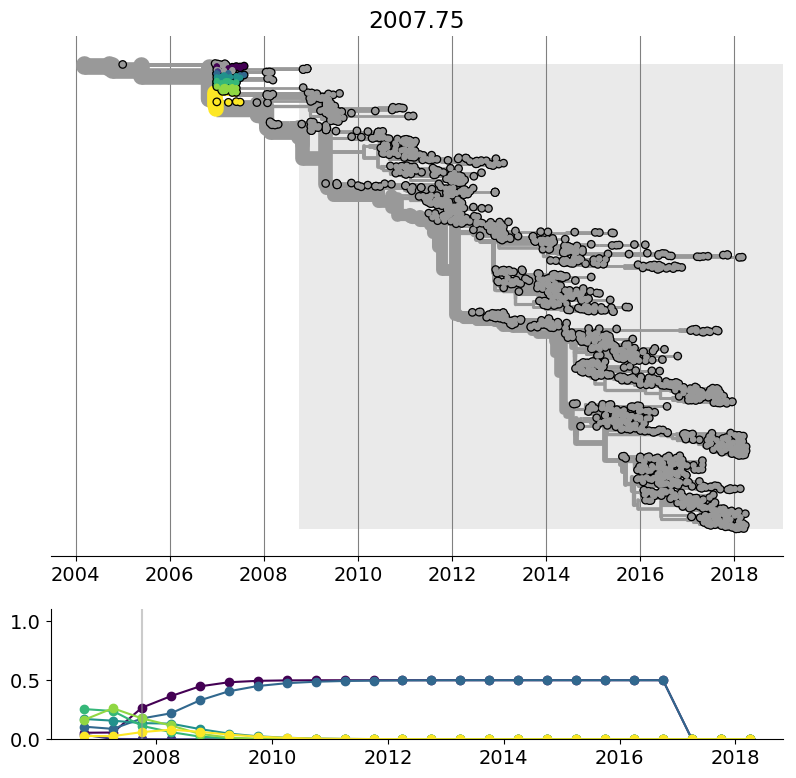

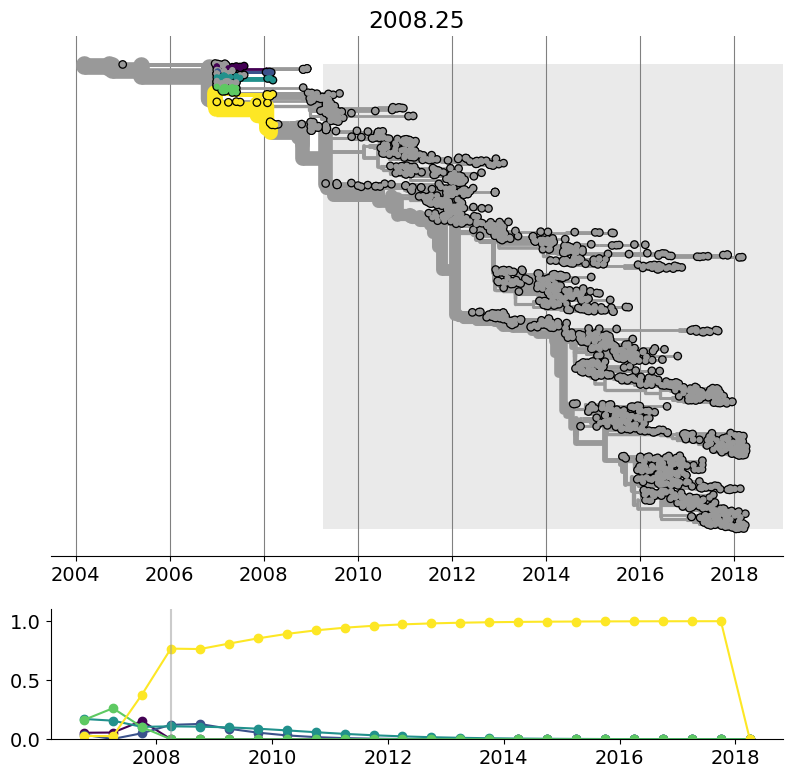

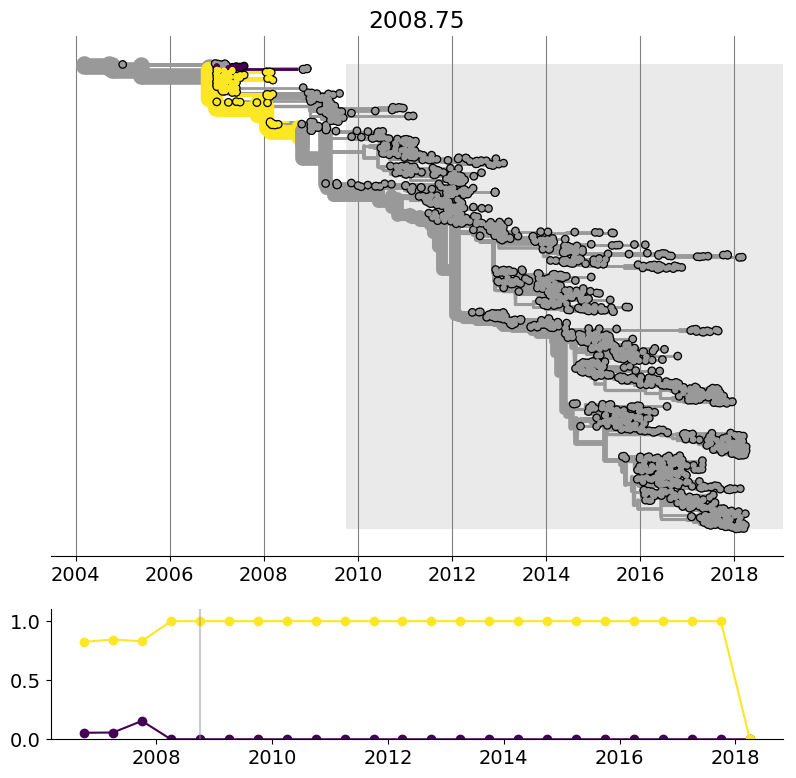

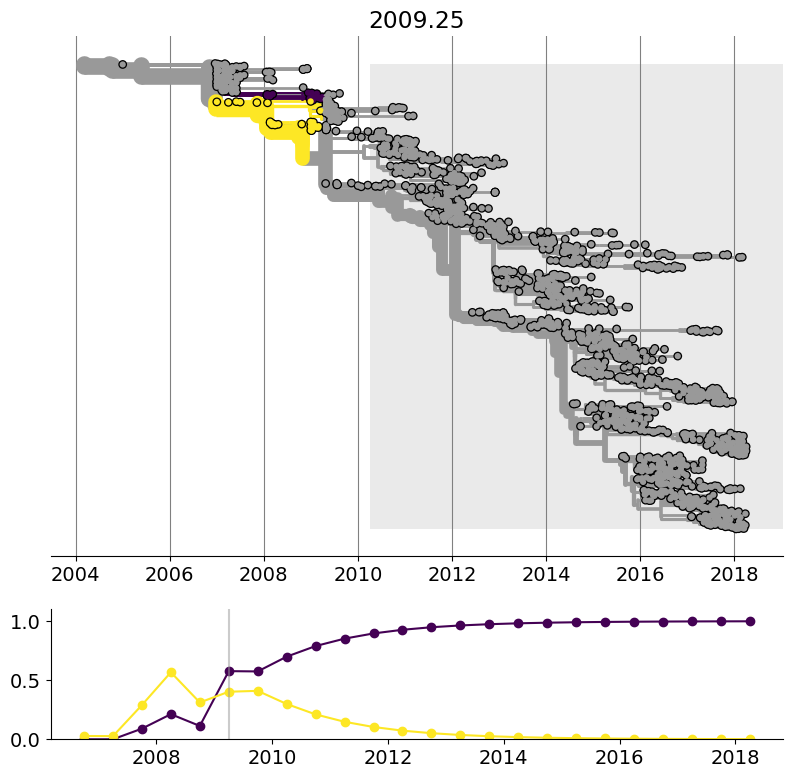

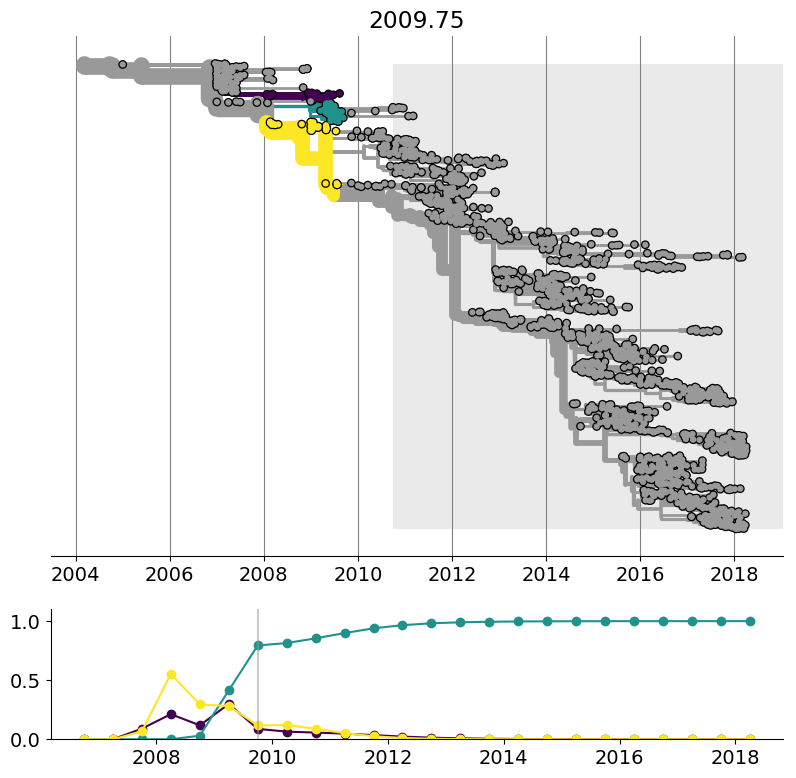

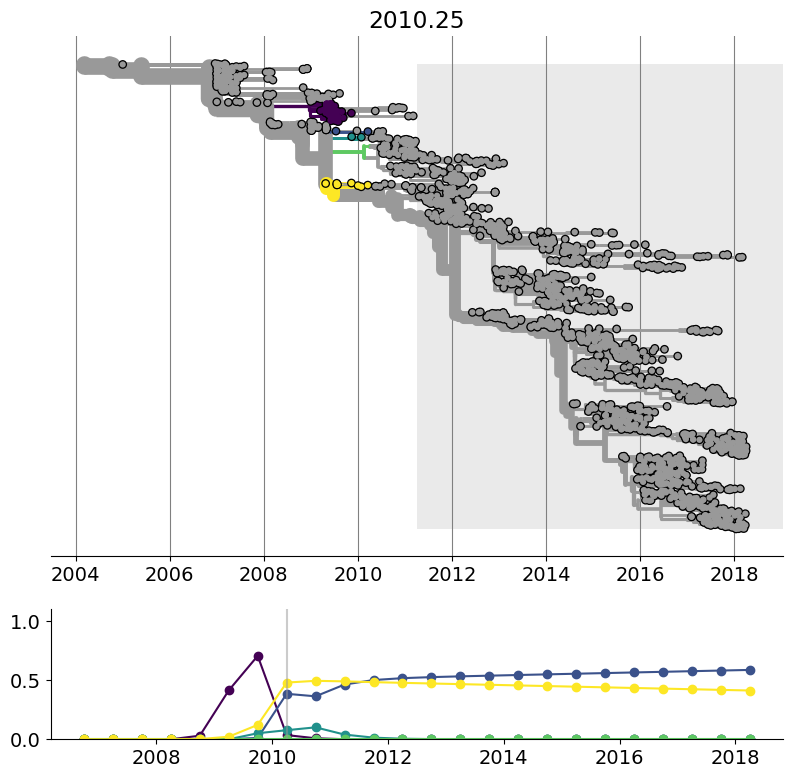

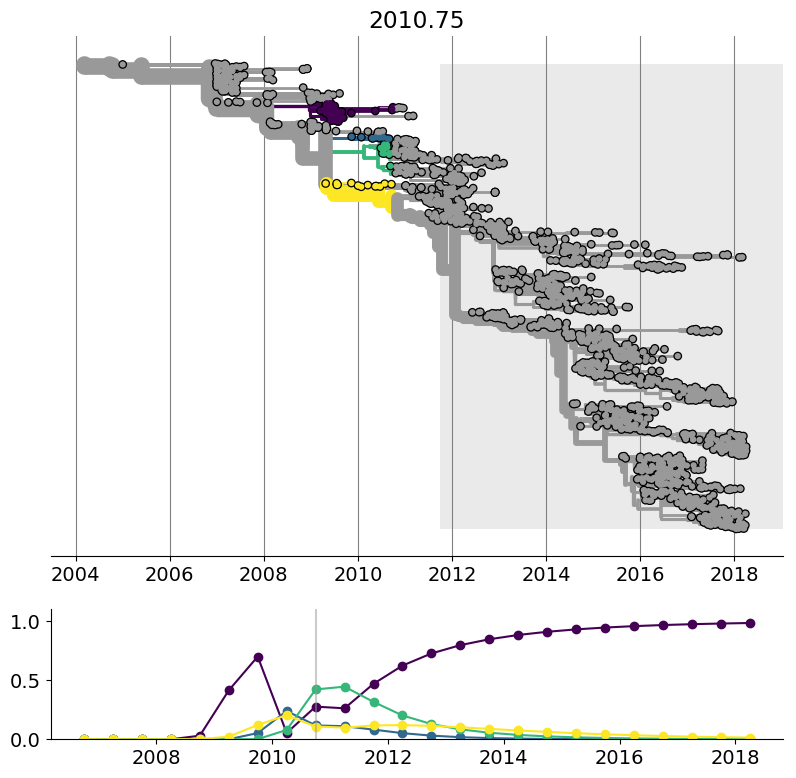

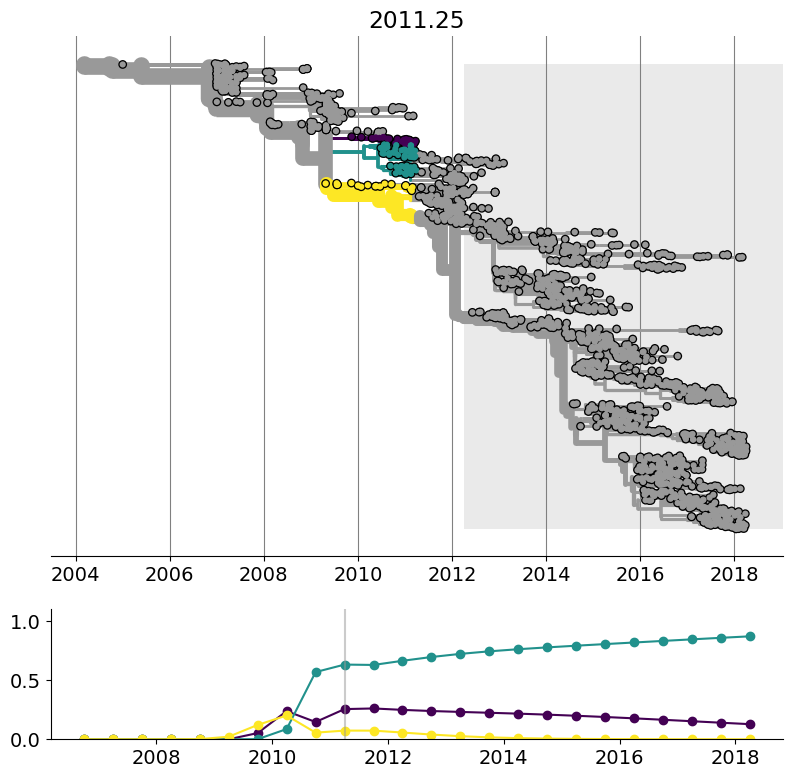

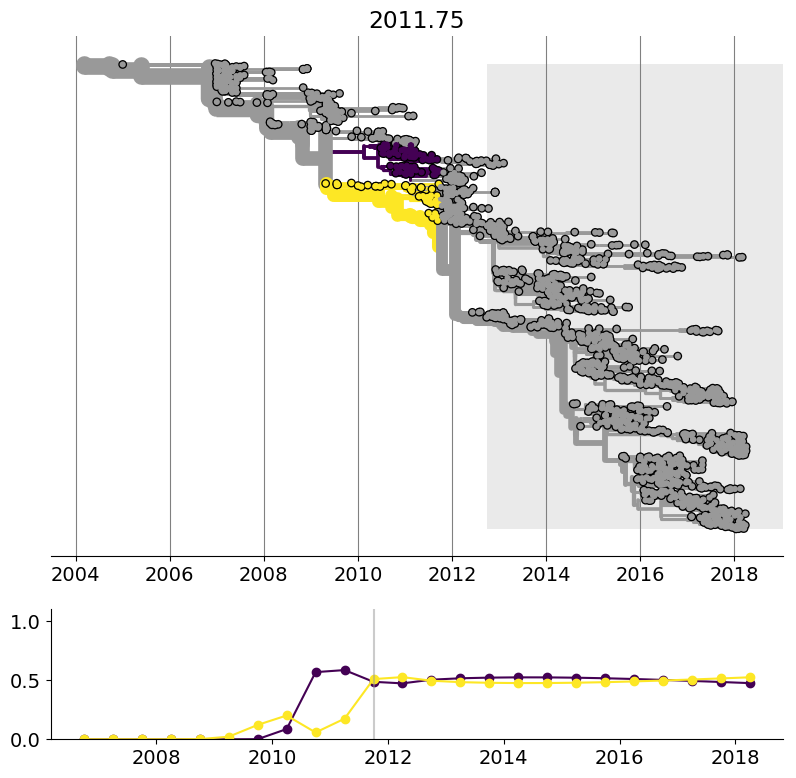

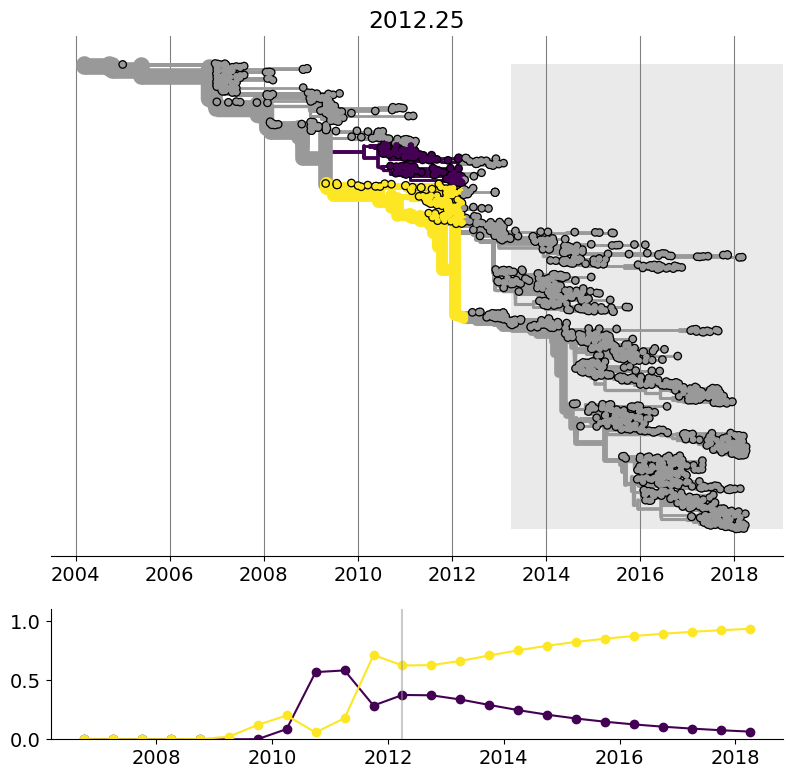

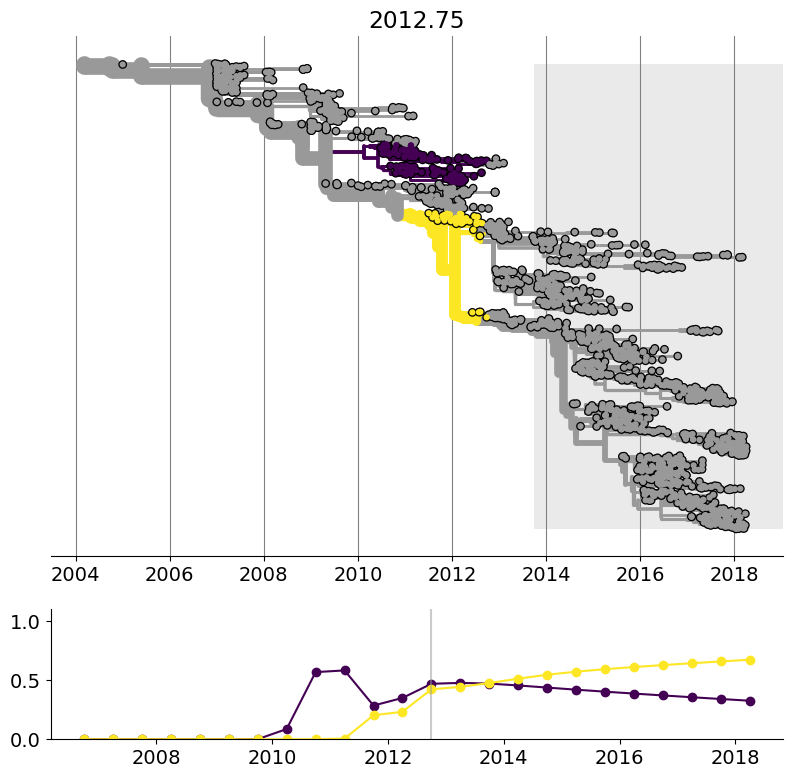

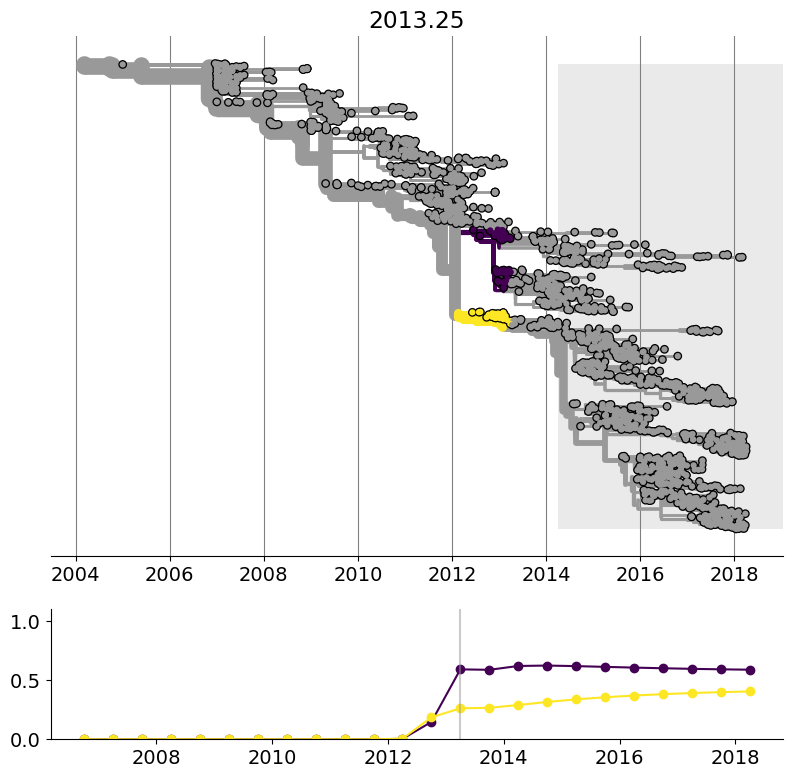

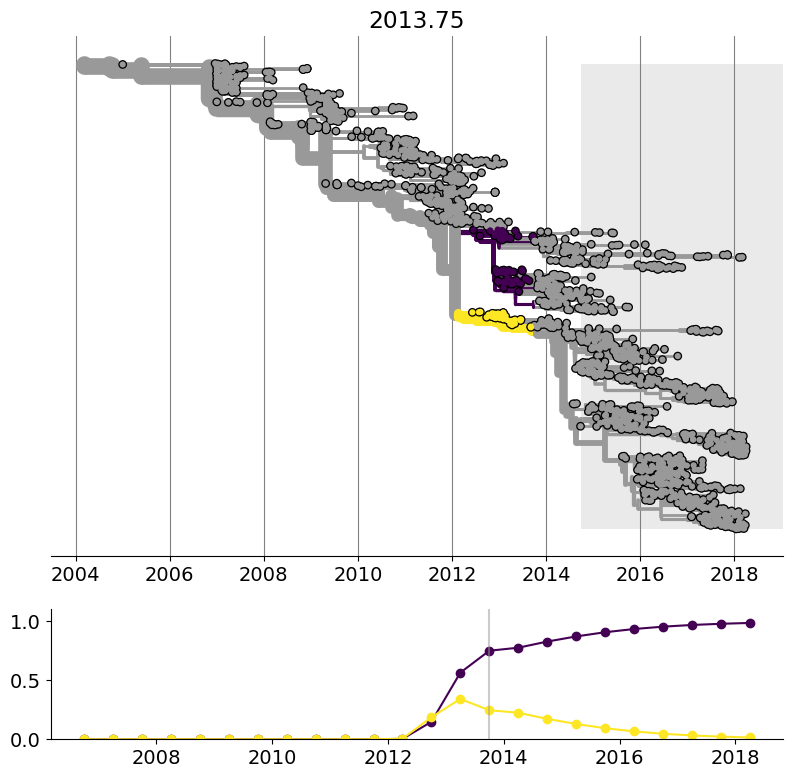

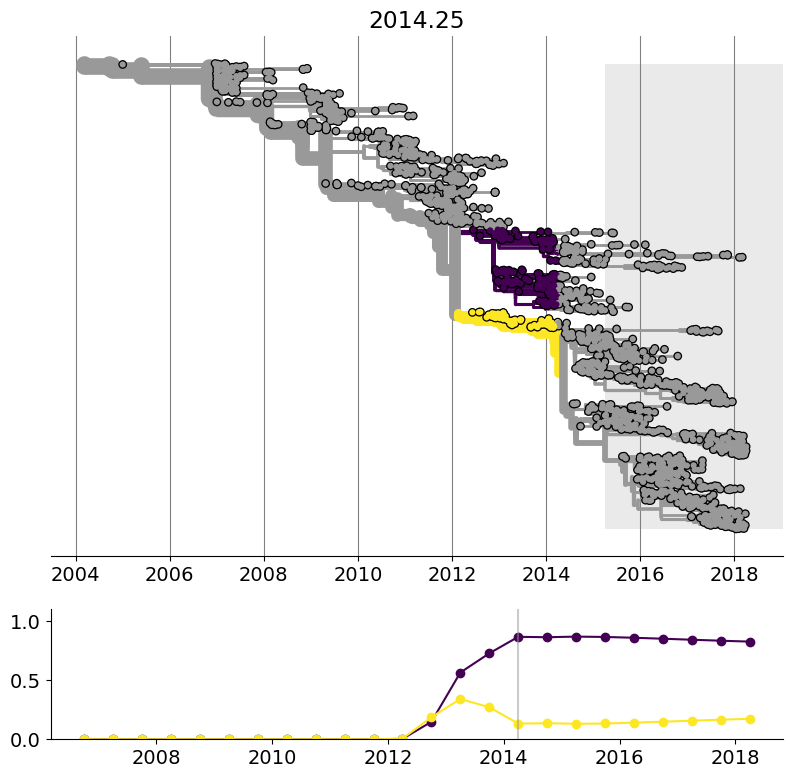

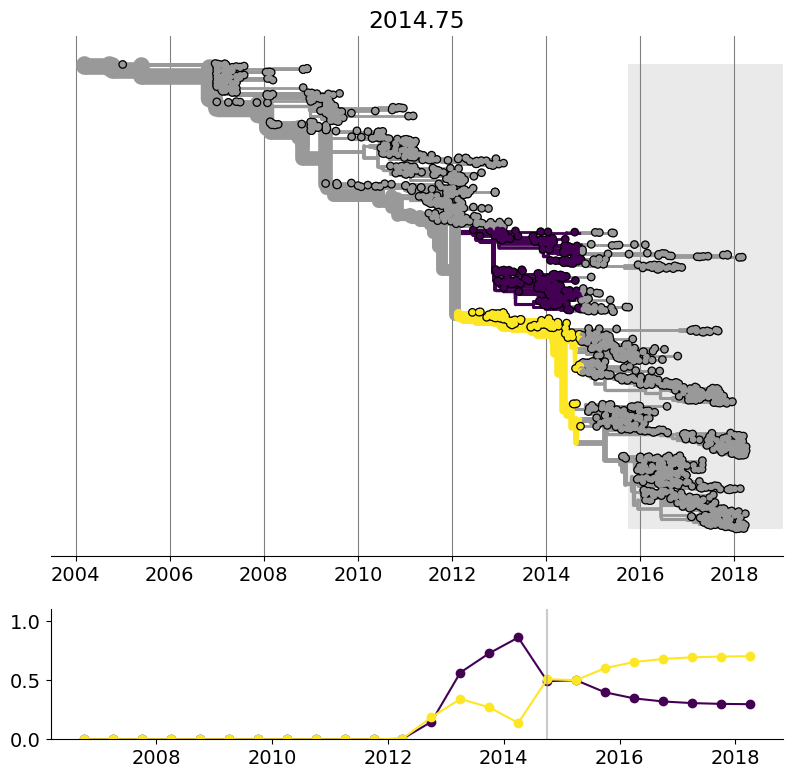

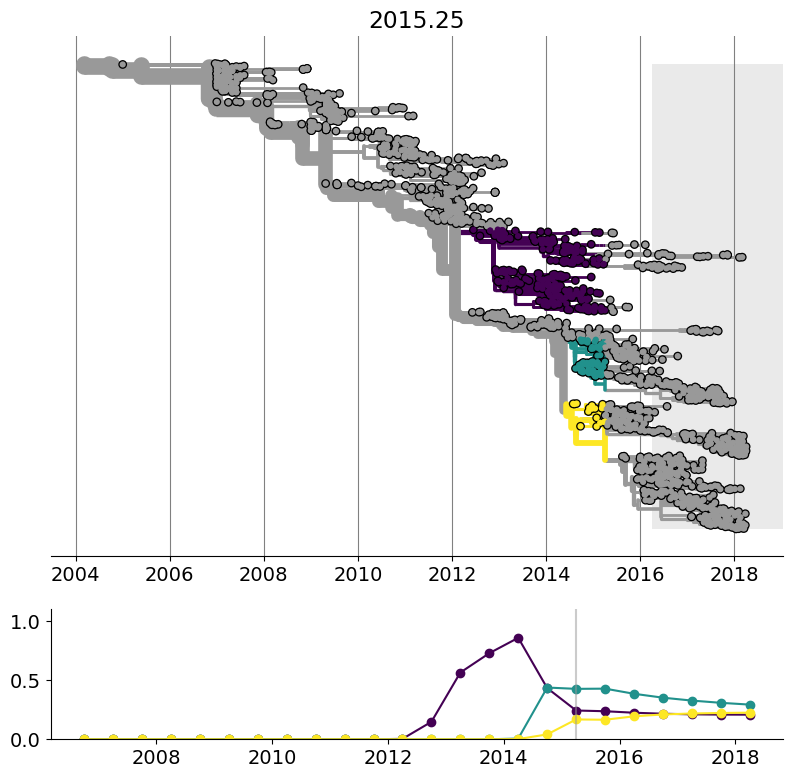

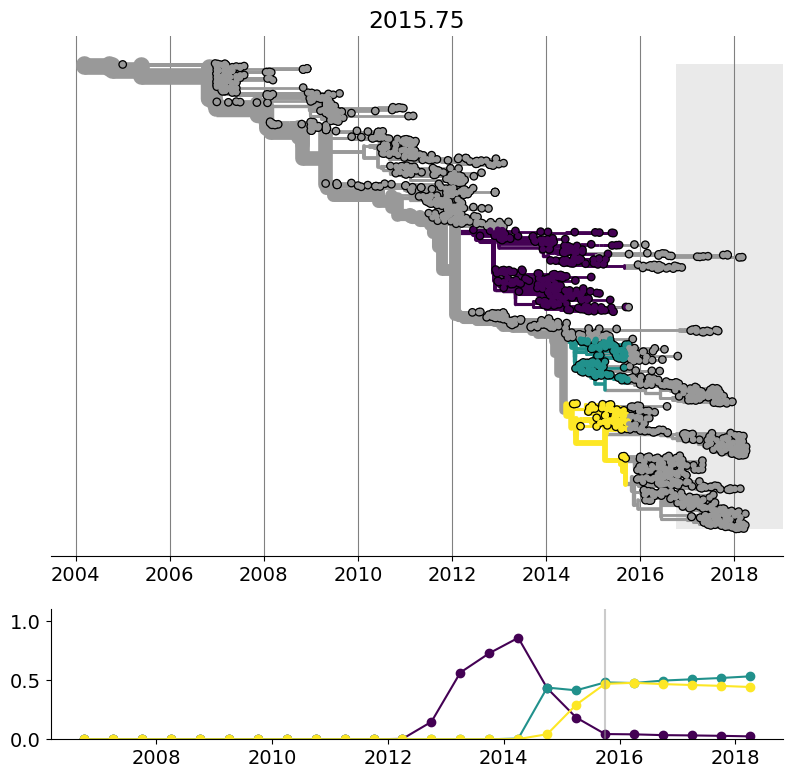

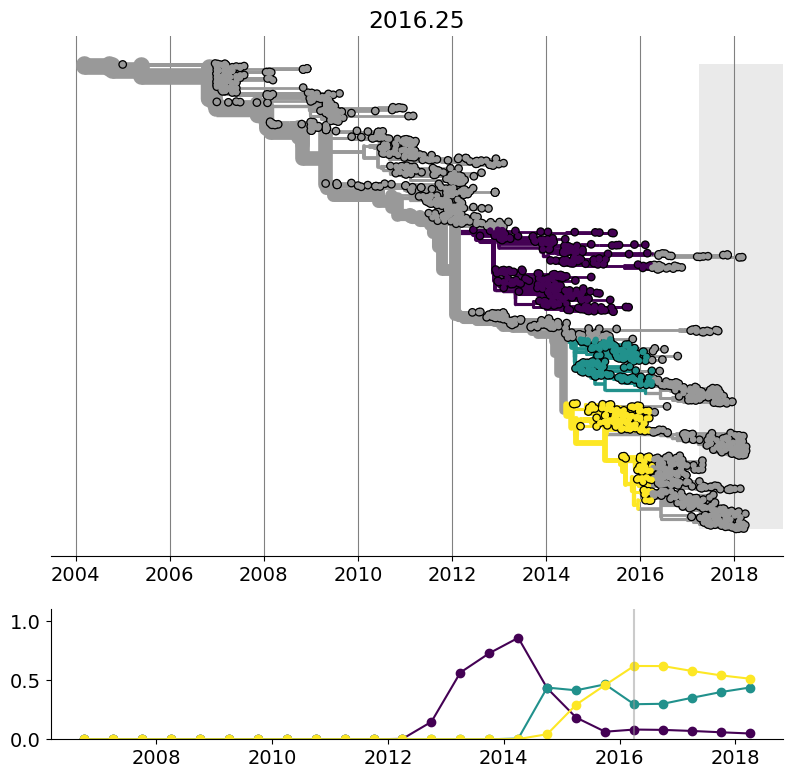

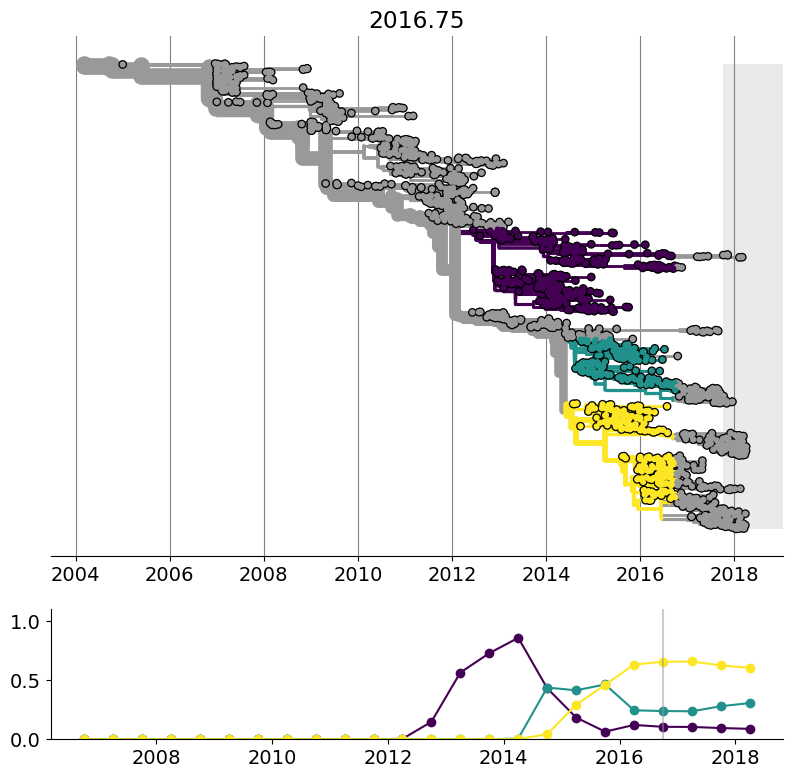

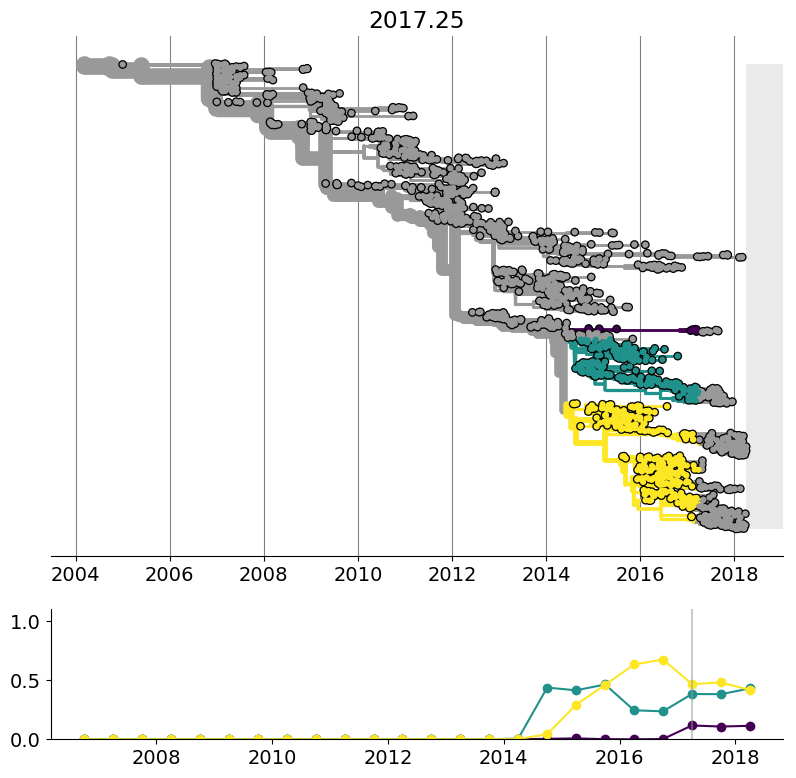

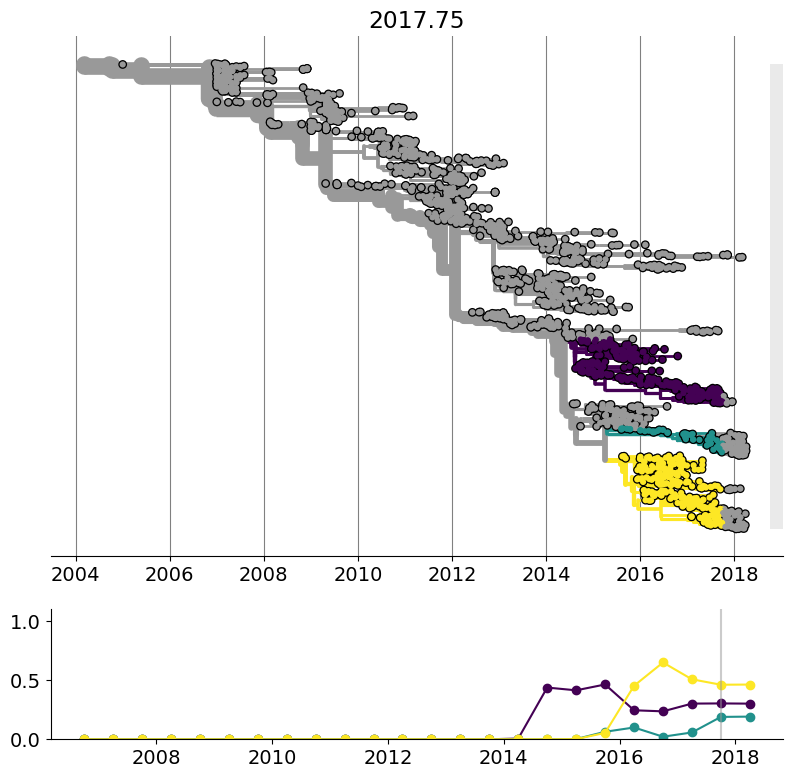

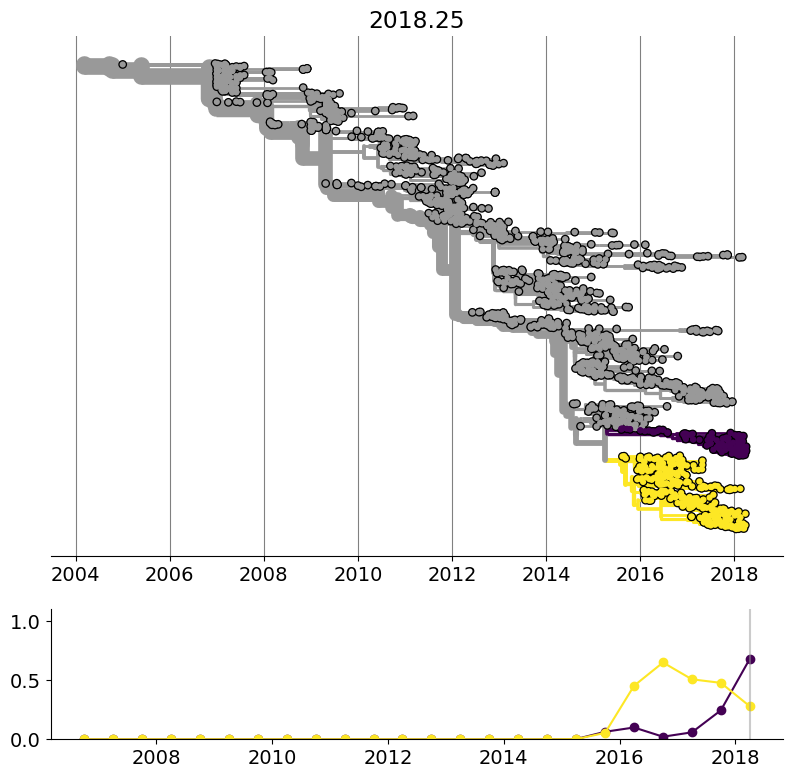

In [41]:
for i, timepoint in enumerate(timepoints):
    clade_group = 0
    total_frequency = 0
    for clade in unnested_clades_by_timepoint[timepoint]:
        total_frequency += frequencies[clade.name][i]
        
    print("%s: %s unnested clades totalling %s" % (timepoint, len(unnested_clades_by_timepoint[timepoint]),
                                                   total_frequency))
    
    if len(unnested_clades_by_timepoint[timepoint]) == 0:
        continue
    
    # Reset attribute on nodes.
    for clade in tree.find_clades():
        if "clade_group" in clade.attr:
            del clade.attr["clade_group"]
    
    children_annotated = 0
    for clade in unnested_clades_by_timepoint[timepoint]:
        clade_group += 1
        for child in clade.find_clades():
            # Only annotate clades that are alive at the current timepoint.
            if child.attr["num_date"] <= timepoint:
                child.attr["clade_group"] = clade_group
                children_annotated += 1
    
    if children_annotated > 0:
        plot_tree(tree, kde_frequencies, timepoint, "clade_group", 10, 20, timepoint, timepoint + 1.0, title=timepoint)
        #plt.close()
    else:
        print("No children annotated with a clade group at %s" % timepoint)

## Yet another approach to defining non-overlapping clades

We cannot simply cut branches at a given timepoint and use the clades that span the cut point.
This results in orphan tips or singleton clades that coalesce in a previous timepoint and there is no reason the true parent of these orphans and their sibling trees should not be considered one of the non-overlapping clades.
We also probably do not want to track single clades from the beginning of time until they die out, at least not at this point.

So, another approach involves a bottom-up selection of non-overlapping clades starting with the tips.
The algorithm goes like this:

1. Make a list of all tips sampled during a given time window
1. Make an empty list of candidate clades
1. For each tip, traverse to upward through its ancestors, adding them to the candidate clades while the following are true:
  1. Adding an ancestor accounts for tips not yet accounted for in the window
  1. The ancestor is the first clade observed outside of the time window
1. Perform a pre-order traversal of the tree and identify all candidate clades that are not nested within other candidate clades

This approach should ensure that every tip sampled in a given time window is properly accounted for and that no tip is represented by multiple clades.
This is the definition of a complete set of non-overlapping clades for any timepoint.
Part of the reason this problem is more complicated than in the original Luksza and Lassig analysis is that their internal nodes did not have independent inferred dates.
Instead, their internal nodes used the latest date of a strain contained within each clade.
Although this approach makes practical sense, it greatly underestimates the coalescence time for clades and places internal nodes closer to other tips than one would expect.
Since our trees have internal node dates inferred by TreeTime, we often observe tips from one season coalescing in a previous season.

In [53]:
previous_timepoint = 2016.75
timepoint = 2017.25

tips_in_window = {}
for node in tree.find_clades():
    if node.is_terminal() and (previous_timepoint <= node.attr["num_date"] < timepoint):
        tips_in_window[node.name] = node

In [54]:
len(tips_in_window)

130

In [55]:
candidate_clades = []

# Order tips by the date of their parents.
# This preferentially adds parents that represent more tips.
tip_names = [key for key, value in sorted(tips_in_window.items(), key=lambda item: item[1].up.attr["num_date"])]

In [56]:
for tip_name in tip_names:
    if tip_name in tips_in_window:
        tip = tips_in_window[tip_name]
        
        # Test whether the tip's parent contains any other tips in this window.
        parent = tip.up
        while parent:
            tips_added_by_parent = 0
            for child in parent.get_terminals():
                if child.name in tips_in_window:
                    # Note that this parent accounts for other tips in this window.
                    tips_added_by_parent += 1
                    del tips_in_window[child.name]

            # Stop adding parents, if doing so provides no new tips.
            # Save the current parent, otherwise.
            if tips_added_by_parent == 0:
                print("No more tips added")
                break
            else:
                print("Adding node %s accounts for %s tips" % (parent.name, tips_added_by_parent))
                candidate_clades.append(parent)
            
            # Stop adding parents, if we have moved outside of the current window.
            # Otherwise, keep traversing upward.
            if parent.attr["num_date"] < previous_timepoint:
                print("Moved outside of window")
                break
            else:
                print("Moving up!")
                parent = parent.up

Adding node NODE_0000722 accounts for 1 tips
Moved outside of window
Adding node NODE_0000278 accounts for 1 tips
Moved outside of window
Adding node NODE_0000295 accounts for 1 tips
Moved outside of window
Adding node NODE_0000421 accounts for 1 tips
Moved outside of window
Adding node NODE_0000349 accounts for 1 tips
Moved outside of window
Adding node NODE_0002781 accounts for 1 tips
Moved outside of window
Adding node NODE_0002749 accounts for 1 tips
Moved outside of window
Adding node NODE_0002815 accounts for 4 tips
Moved outside of window
Adding node NODE_0002791 accounts for 1 tips
Moved outside of window
Adding node NODE_0000448 accounts for 2 tips
Moved outside of window
Adding node NODE_0000753 accounts for 32 tips
Moved outside of window
Adding node NODE_0000470 accounts for 26 tips
Moved outside of window
Adding node NODE_0000339 accounts for 1 tips
Moved outside of window
Adding node NODE_0000364 accounts for 1 tips
Moved outside of window
Adding node NODE_0002787 account

In [57]:
tips_in_window

{}

In [58]:
# Reset attribute on nodes.
for clade in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

for clade in tree.find_clades():
    if clade in candidate_clades:
        clade.attr["clade_group"] = 1

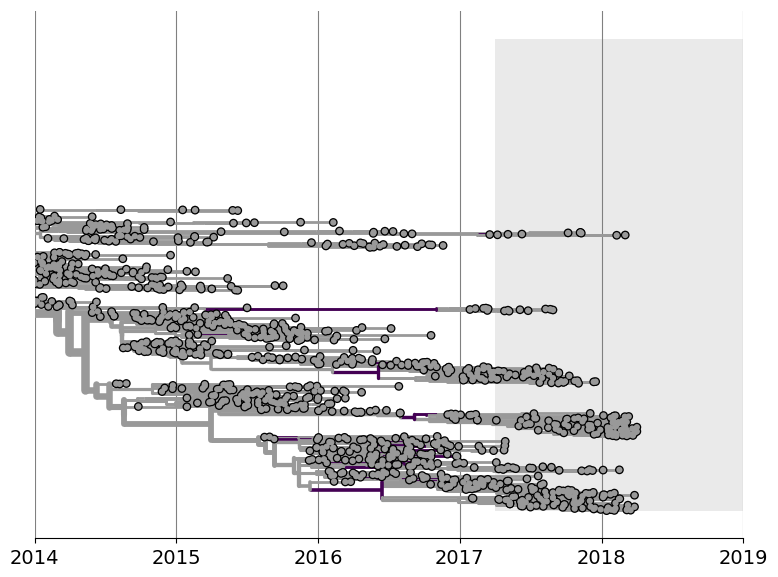

In [59]:
ax, freq_ax = plot_tree(tree, None, start_date, "clade_group", 10, 20, previous_timepoint, timepoint,
                        min_date=2014, max_date=2019)

In [60]:
# Reset attribute on nodes.
for clade in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

clade_group = 0
clades = {}
for clade in tree.find_clades():
    if clade.up and "clade_group" in clade.up.attr and clade.attr["num_date"] < timepoint:
        clade.attr["clade_group"] = clade.up.attr["clade_group"]
    elif clade in candidate_clades:
        clade_group += 1
        clade.attr["clade_group"] = clade_group
        clades[clade_group] = clade

In [61]:
clade_group

32

(-20, 800)

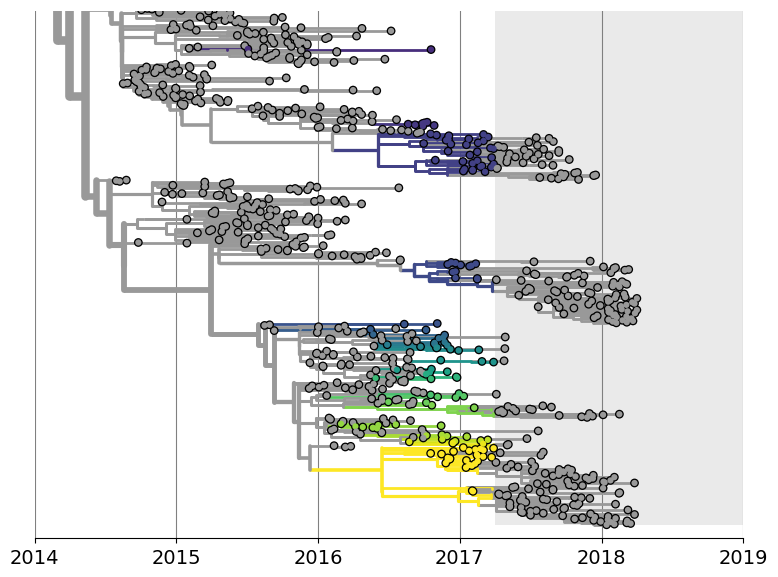

In [62]:
ax, freq_ax = plot_tree(tree, None, start_date, "clade_group", 10, 20, previous_timepoint, timepoint,
                        min_date=2014, max_date=2019)
ax.set_ylim(-20, 800)

## Identify non-overlapping clades as in Luksza and Lassig

In Luksza and Lassig 2014, nonoverlapping clades are defined by removing all strains from any given clade that belong to a proper subset of that clade.
My algorithmic interpretation of this mathematical formulation is that we must find all minimal clades at each timepoint that do not themselves contain any other clades.
This definition should produce many small clades, in contrast to most of the methods above which try to identify reasonably large clades (>10%).

The actual algorithm works by postorder traversal of the tree:

  1. If clade group already assigned or if tip is not alive during the current season, continue to next node.
  1. Otherwise, assign the next available group number to the current tip, all of its terminal siblings, and its parent node.
  1. Increment the group number.

In [114]:
previous_timepoint

2016.75

In [115]:
timepoint

2017.25

In [116]:
timepoint_index = np.searchsorted(kde_frequencies.pivots, timepoint)

In [117]:
kde_frequencies.pivots[timepoint_index]

2017.25

In [118]:
kde_frequencies.frequencies[clade.name][timepoint_index]

8.847817199775602e-22

In [134]:
# Reset attribute on nodes.
for clade in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

epsilon = 1e-3
clade_group = 0
clades = {}
for clade in tree.get_terminals(order="postorder"):
    # Skip this tip if it already has a clade group or if it is not alive right now.
    if "clade_group" in clade.attr or kde_frequencies.frequencies[clade.name][timepoint_index] < epsilon:
        continue
        
    # Assign clade group to this tip and its immediate siblings.
    for sibling in clade.up.clades:
        if sibling.is_terminal() and kde_frequencies.frequencies[sibling.name][timepoint_index] >= epsilon:
            sibling.attr["clade_group"] = clade_group

    # Confirm that this tip was assigned to the clade group.
    assert clade.attr["clade_group"] == clade_group

    # Assign clade group to this tip's parent node and track the parent node as a candidate clade.
    clade.up.attr["clade_group"] = clade_group
    clades[clade_group] = clade.up
    
    # Increment the clade group value.
    clade_group += 1

In [135]:
clade_group

77

In [128]:
tips_per_clade_group = defaultdict(int)
total_frequency = 0.0
for tip in tree.get_terminals():
    if "clade_group" in tip.attr:
        tips_per_clade_group[tip.attr["clade_group"]] += 1
        total_frequency += kde_frequencies.frequencies[tip.name][timepoint_index]

In [129]:
total_frequency

0.98479832829376701

In [130]:
len(tips_per_clade_group)

77

In [131]:
np.array(tips_per_clade_group.values())

array([1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 3, 2, 2, 1, 1, 2, 2])

In [133]:
pd.Series(np.array(tips_per_clade_group.values())).value_counts()

1    50
2    25
3     2
dtype: int64

(-20, 800)

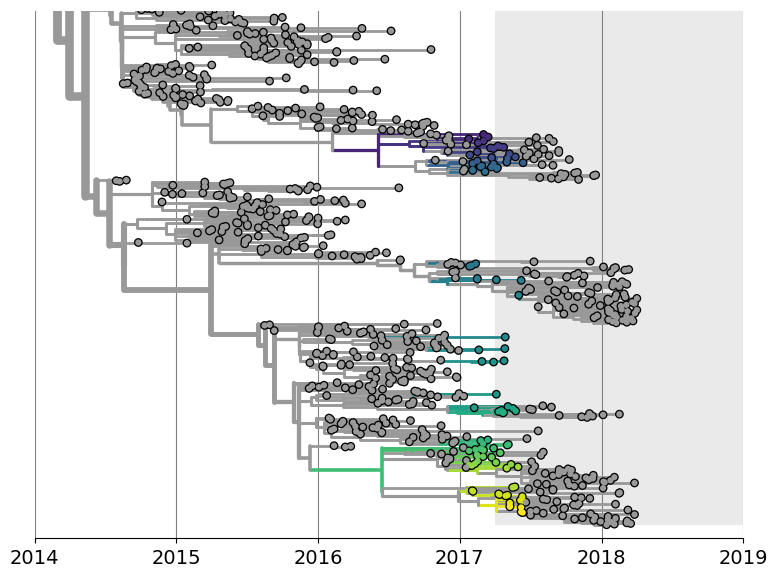

In [132]:
ax, freq_ax = plot_tree(tree, None, start_date, "clade_group", 10, 20, previous_timepoint, timepoint,
                        min_date=2014, max_date=2019)
ax.set_ylim(-20, 800)

In [138]:
np.array([kde_frequencies.frequencies[clade.name][timepoint_index] for clade in clades.itervalues()]).sum()

2.4142025767690489

## Identify clades by amino acid mutations

As an alternative to identifying non-overlapping clades, we may want to find clades distinguished by amino acid mutations such that a nested clade could be included in an analysis if it picked up a novel epitope mutation.

For the first pass of the analysis, simply identify clades based on their acquisition of a novel amino acid mutation (regardless of its epitope status) and plot the results.


In [41]:
tree

Clade(branch_length=0, clade=3616, name='NODE_0002002', numdate=2004.18074399, strain='NODE_0002002', yvalue=1985.83086672)

In [69]:
clades_with_mutations = {}
for node in tree.find_clades():
    mutations = sum([len(muts) for gene, muts in node.aa_muts.items() if gene == "HA1"])
    if mutations > 0:
        mutation = "-".join(node.aa_muts["HA1"])
        if mutation not in clades_with_mutations:
            clades_with_mutations[mutation] = []

        clades_with_mutations[mutation].append(node)

In [73]:
# Clear previous group annotations.
for node in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

# Annotate clade groups for all clades sharing the same mutation(s).
clade_group = 0
for mutation, clades in clades_with_mutations.items():
    for clade in clades:
        clade.attr["clade_group"] = clade_group
    
    clade_group += 1

In [74]:
len(clades_with_mutations)

480

In [75]:
clades_with_mutations.keys()[:10]

[u'Q197R',
 u'I242R',
 u'I242T',
 u'I242V',
 u'H94Q',
 u'Q197H',
 u'I242L',
 u'I242M',
 u'V168M',
 u'N144K']

(-20, 800)

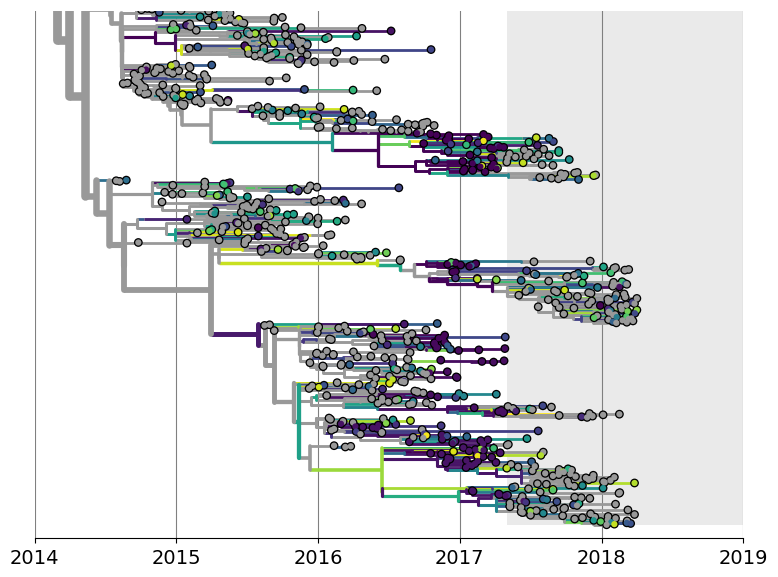

In [78]:
ax, freq_ax = plot_tree(tree, None, start_date, "clade_group", 10, 20, previous_timepoint, timepoint,
                        min_date=2014, max_date=2019)
ax.set_ylim(-20, 800)

In [79]:
node.attr

{u'authors': u'instituto_de_salud_carlos_iii',
 u'clade_membership': u'A1b/135K',
 u'clock_length': 0.00033187309172972256,
 u'country': u'spain',
 u'country_confidence': {u'spain': 1.0},
 u'country_entropy': -1.000088900581841e-12,
 u'date': u'2018-01-14',
 u'div': 0.05002103769289381,
 u'ep': 21,
 u'lbi': 0.29437312469010496,
 u'ne': 10,
 u'num_date': 2018.0355920605077,
 u'raw_date': u'2018-01-13',
 u'rbs': 4,
 u'region': u'europe',
 u'region_confidence': {u'europe': 1.0},
 u'region_entropy': -1.000088900581841e-12}

In [98]:
node.up.attr

{u'clade_membership': u'A1b/135K',
 u'clock_length': 1.5371727403960117e-05,
 u'country': u'spain',
 u'country_confidence': {u'spain': 0.9999864087558975},
 u'country_entropy': 0.00018717396514220214,
 u'date': u'2017-12-11',
 u'div': 0.05002103769289379,
 u'ep': 21,
 u'lbi': 0.35330484628257597,
 u'ne': 10,
 u'num_date': 2017.9443504719136,
 u'rbs': 4,
 u'region': u'europe',
 u'region_confidence': {u'europe': 0.9988749573504915},
 u'region_entropy': 0.01010004822499156}

Use a change in the number of epitope mutations from the root as the indicator that a clade should be in a new group.

In [147]:
# Assign a default clade group to all nodes.
clade_group = 0
clade_name_by_clade_group = {}

for node in tree.find_clades():
    node.attr["clade_group"] = clade_group

# Assign clade groups to nodes.
clade_group += 1
for node in tree.find_clades():
    if node.up and node.up.attr["ep"] != node.attr["ep"]:
        node.attr["clade_group"] = clade_group
        clade_name_by_clade_group[clade_group] = node.name
        clade_group += 1

In [148]:
clade_group

577

In [150]:
# Assign clade groups from parents to nodes that have the default group.
for node in tree.find_clades():
    if node.up and node.attr["clade_group"] == 0:
        node.attr["clade_group"] = node.up.attr["clade_group"]

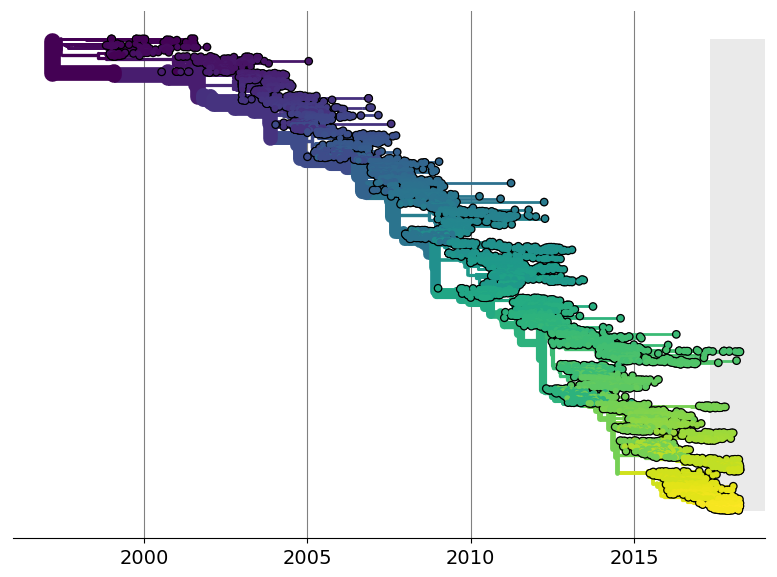

In [188]:
ax, freq_ax = plot_tree(tree, None, start_date, "clade_group", 10, 20, previous_timepoint, timepoint,
                        min_date=1996, max_date=2019)
#ax.set_ylim(-20, 800)

(array([ 354.,  361.,  509.,  712.,  199.,  707.,  351.,  179.,  599.,  307.]),
 array([   0. ,   57.6,  115.2,  172.8,  230.4,  288. ,  345.6,  403.2,
         460.8,  518.4,  576. ]),
 <a list of 10 Patch objects>)

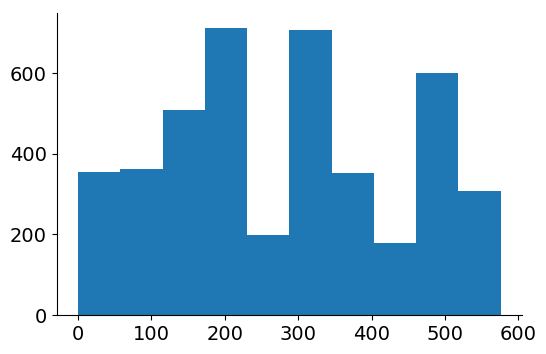

In [152]:
clade_groups = np.array([node.attr["clade_group"] for node in tree.find_clades()])
plt.hist(clade_groups, bins=10)

In [141]:
clade_groups

array([  0,   1,   2, ..., 526, 526, 526])

In [142]:
max(clade_groups)

529

In [143]:
min(clade_groups)

0

In [144]:
np.mean(clade_groups)

247.66685098147636

## Find clades by epitope mutations in long-term tree

In [175]:
with open("flu_h3n2_ha_1998-2018y_50v_0_tree.json", "r") as fh:
    tree_json = json.load(fh)

tree = json_to_tree(tree_json)

In [176]:
len(tree.get_terminals())

7959

In [180]:
# Assign a default clade group to all nodes.
clade_group = 0
clade_name_by_clade_group = {
    0: tree.root.name
}

for node in tree.find_clades():
    node.attr["clade_group"] = clade_group

# Assign clade groups to nodes.
clade_group += 1
for node in tree.find_clades():
    if node.up and node.up.attr["ep"] != node.attr["ep"]:
        node.attr["clade_group"] = clade_group
        clade_name_by_clade_group[clade_group] = node.name
        clade_group += 1

# Assign clade groups from parents to nodes that have the default group.
for node in tree.find_clades():
    if node.up and node.attr["clade_group"] == 0:
        node.attr["clade_group"] = node.up.attr["clade_group"]

In [181]:
clade_group

2044

In [182]:
records = []
for node in tree.find_clades():
    if node.is_terminal():
        records.append({
            "name": node.name,
            "inferred_date": node.attr["num_date"],
            "raw_date": node.attr["raw_date"],
            "epitope_mutations": node.attr["ep"],
            "cluster_id": clade_name_by_clade_group[node.attr["clade_group"]]
        })

df = pd.DataFrame(records)

In [183]:
df.head(10)

cluster_id  epitope_mutations  inferred_date  \
0             A/Dakar/26/2001                  4    2001.446270   
1  A/WesternAustralia/13/2001                  7    2001.525667   
2                NODE_0000468                  2    1999.002738   
3          A/NewYork/423/1999                  3    1999.958248   
4                NODE_0000468                  2    1999.780287   
5          A/NewYork/435/2000                  3    2000.024641   
6          A/NewYork/145/1999                  4    1999.856947   
7                NODE_0000468                  2    1999.755647   
8                NODE_0000468                  2    1999.758385   
9                NODE_0000468                  2    1999.002738   

                         name    raw_date  
0             A/Dakar/26/2001  2001-06-12  
1  A/WesternAustralia/13/2001  2001-07-11  
2      A/Netherlands/301/1999  1999-01-01  
3          A/NewYork/423/1999  1999-12-16  
4     A/Georgia/NHRC0001/1999  1999-10-12  
5          A/NewYork/435/2000  2000-01-09  
6          A/NewYork/145/1999  1999-11-09  
7          A/NewYork/138/1999  1999-10-03  
8          A/NewYork/137/1999  1999-10-04  
9     A/NewSouthWales/20/1999  1999-01-01

In [184]:
df.tail(10)

cluster_id  epitope_mutations  inferred_date  \
7949                  NODE_0007832                 28    2017.665298   
7950                  NODE_0007832                 28    2017.793977   
7951  A/DistrictOfColumbia/18/2018                 29    2018.199863   
7952                  NODE_0007832                 28    2018.210815   
7953                  NODE_0007832                 28    2018.005476   
7954                  NODE_0007832                 28    2017.856947   
7955                  NODE_0007832                 28    2017.908966   
7956                  NODE_0007832                 28    2017.925394   
7957                  NODE_0007832                 28    2017.870637   
7958                  NODE_0007832                 28    2017.856947   

                               name    raw_date  
7949          A/Vietnam/GHS890/2017  2017-08-31  
7950        A/England/74300448/2017  2017-10-17  
7951   A/DistrictOfColumbia/18/2018  2018-03-14  
7952            A/Niigata-C/21/2018  2018-03-18  
7953       A/Tianjin-Nankai/17/2018  2018-01-02  
7954         A/Baleares/180420/2017  2017-11-09  
7955            A/Yokohama/181/2017  2017-11-28  
7956  A/Beijing-Chaoyang/12911/2017  2017-12-04  
7957              A/Sydney/235/2017  2017-11-14  
7958          A/Cambodia/36954/2017  2017-11-09

In [186]:
df.shape

(7959, 5)

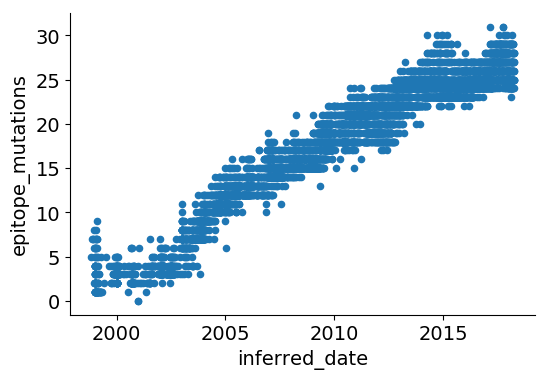

In [185]:
df.plot(x="inferred_date", y="epitope_mutations", kind="scatter")